## Breast Cancer Prediction

***

Health is an essential aspect of everyone’s life. Breast cancer is found in the body of male or female when the cells in the breast begin to grow out of control. These cells usually form a tumor and can be felt as a lump or could be seen on an x-ray. Cancer can be distinguished as benign, or either can be malignant (cancer).

About the Data set:

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. 

About this notebook:

The goal of this notebook is to perform feature selection, then train a variety of binary classification models to make predictions as to whether or not a tumor is benign or malignant. After training these models, we will provide each model with a standardized set of testing data. Once each model has made predictions on the testing data, we'll compare select performance metrics and select a model that best classifies the data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import urllib
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from IPython.display import Image
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Takeaways from looking at the data set are: 
* 'id' is of no real use
* 'diagnosis' currently contains the class labels and will need to be converted to 0's and 1's
* 'Unnamed: 32' is a column full of NaN values, so we can also remove this column

In [4]:
# Dropping id and Unnamed:32 columns

dropped_col = ['id', 'Unnamed: 32'] 
data.drop(dropped_col, axis=1, inplace=True)
y = data['diagnosis']

# Converting class labels to integer representation

temp = pd.get_dummies(data["diagnosis"])
data = pd.concat((temp, data), axis=1)
data= data.drop(["diagnosis"], axis=1)
data = data.drop(["B"], axis=1)
data = data.rename(columns={"M": "diagnosis"})
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Due to how we went about converting our class labels to integers (0's and 1's), a diagnosis represented by a 1 is equal to malignant (M) and a diagnosis represented by a zero is equal to begnin (B) <br>

We also now have a dataframe containing 31 columns or 30 features and a class label

Separating out the label 'diagnosis' from our feature set and creating our training and testing subsets<br>
Using a standard 70/30 training/testing data split

In [5]:
y_binary = data['diagnosis']
x = data.drop('diagnosis', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

Looking at the number of malignant observations (class 1) and benign observations (class 0) in the data set, we can see that malignant observations make up the majority class with benign observations making up the minority class. The distribution of our classes is a 1.68 ratio malignant to benign observations. 

This ratio is small enough that we don't need to be concerned with the imbalance of class observations


In [6]:
data['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [7]:
print(data.isnull().sum())

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [8]:
df_zeros = pd.DataFrame({})
for column_name in data.columns:
    column = data[column_name]
    count = (column == 0).sum()
    if count != 0:
        df_zeros.insert(len(df_zeros.columns), column_name, [count])

df_zeros

,diagnosis,concavity_mean,concave points_mean,concavity_se,concave points_se,concavity_worst,concave points_worst
0,357,13,13,13,13,13,13


After examining our data set for null values and zero values, there exists no null values and 13 observations with six features having zero value. 

These zero values lie in features; 

* 'concavity_mean'
* 'concave points_mean'
* 'concavity_se
* 'concave points_se
* 'concavity_worst'
* 'concave points_worst'

These zero values looking at the data distributions below of the six features, appear to be valid data

In [9]:
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Looking at the above metrics we can both get a high level idea of the data distributions of each feature as well as take a look at the scales each feature is on.<br>

This lets us know that we might consider normalization of the data for plotting purposes.

#####  Data Visualization

Let's look at a correlation map of all features to get an idea of the relationships/dependencies that exist between our features

[Text(0.5, 1, 'Pearson Correlation Coefficient Heatmap')]

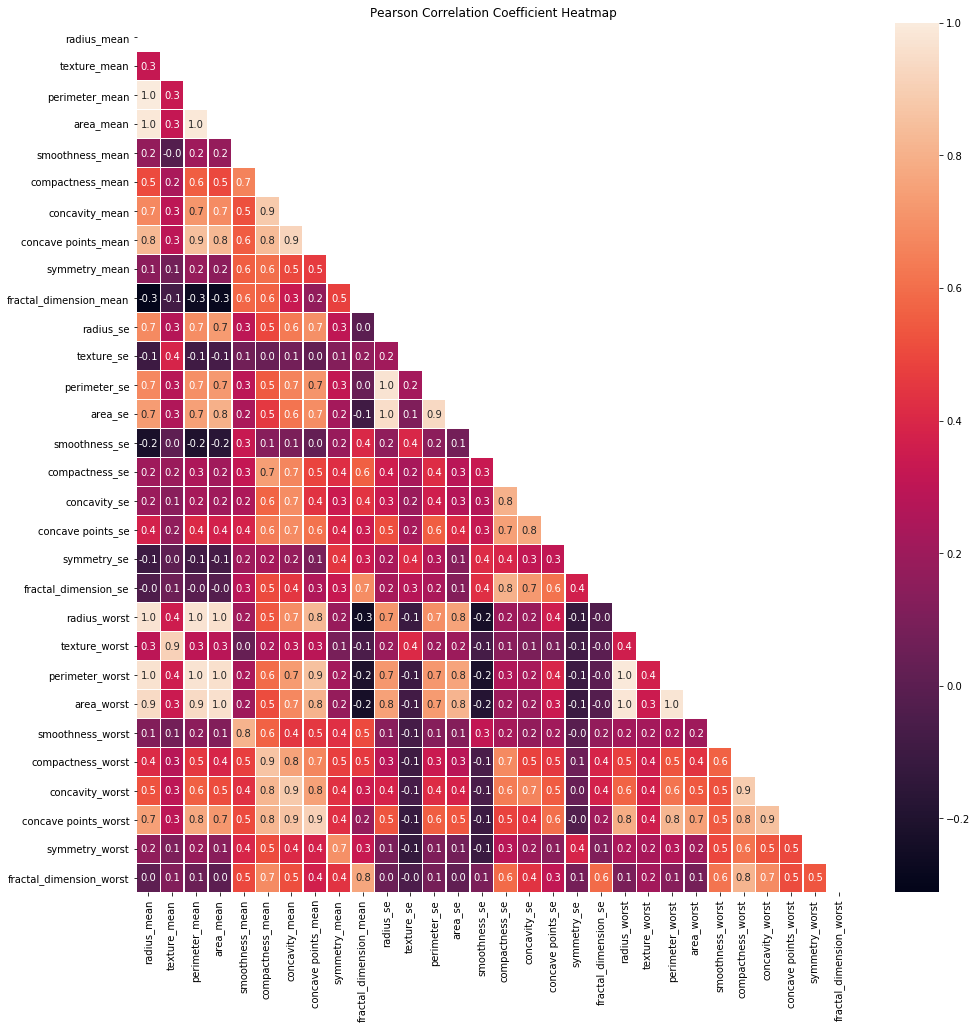

In [10]:
corr = x.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize = (16,16))
sns.heatmap(corr, mask=mask, annot=True, linewidths=0.5, fmt='.1f').set(title='Pearson Correlation Coefficient Heatmap')

What are we looking at?

The values above are the Pearson Correlation coefficients. These coefficients indicate what type and the strength of the relationship/dependency between two features
 
Correlations range from -1 to 1 with,

* -1 correlation shows two variables are highly negatively dependent
* 0 correlation meaning there exists no relationship or dependency between two variables
* 1 correlation meaning two variables are highly positively dependent


What information do we gain from the above feature correlation heatmap? 

We can see in the figure above that there exist some highly positively correlated features (> 0.7) in the feature space.

Features that are highly correlated can contain redundant information that in could even hinder a models accuracy. This extra information is simply adding noise to the system. This is one of the benefits of feature selection highlighted in the section that follows. 

###  Feature Selection

***

##### Overview

Feature selection is primarily focused on removing non-informative or redundant predictors from the model.

Reducing the number of features used in statistical analysis can lead to benefits such as:

* Improved Accuracy:
* Reduction in Overfitting Risk: Less redundant data (highly correlated features) means fewer chances of making decisions based on noise.
* Improved training times: Less features


Feature selection can be done with a variety of methods.

Three Types of Feature Selection:

* Wrapper-based Methods: Forward, Backward, and Stepwise Selection
* Filter-based Methods: ANOVA, Pearson Correlation, Variance Thresholding, 
* Embedded Methods: Lasso, Ridge, and Decision Trees. Algorithms that have built in feature selection

##### Feature Selection on Our Data Set

For our feature selection I have chosen to use a recursice feature elimination with cross validation (RFECV)

RFECV was chosen as this method of feature selection finds both the best features in terms of model classification accuracy as well as the number of features that gives us this model.

RFECV selects the best subset of features for a supplied estimator. 

We have selected a Random Forest Classifier. This estimator fits a number of decision tree classifiers on a subset of the data set and uses majority voting to improve the predictive accuracy and limit overfitting of the model. 

Decision Trees use multiple algorithms to decide to split a node into two or more sub-nodes. The sub-nodes split the data to increase the homogeneity of resultant sub-nodes. In other words the purity of nodes increases with respect to the target variable. The decision tree splits the nodes on all available features and then selects the split which results in the most homogeneous or pure sub-nodes.

RFECV selects the best subset of features by removing 0 to N features, where N is the number of features, using recursive feature elimination then selecting the best subset based of the cross-validation score of the model.

As stated above, RFECV removes 0 to N features from the feature space, therefore RFECV would fall under the category of a backward feature selection method.


<font color = 'gray'>
Note: We need to set the seed for the random forest classifier used below in our recursive feature elimination, since every time we fit the model, randomness is introduced to the system by the 'bootstrap' and 'max_features' parameters of the classifier.


In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=2)
rfecv = RFECV(model, step = 1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(x_train, y_train)
rfecv.n_features_

9

After running our recursive feature elimination with cross validation, the model that yields the highest cross validation score was trained on 9 features.

We can see what these optimal features are using the method below

In [12]:
x_train.columns[rfecv.support_]

Index(['perimeter_mean', 'concavity_mean', 'concave points_mean',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')

We can also take a look at the models cross validation scores for the varying number of features include in the model, ranging from one to all available features included in the model. 

We can plot the scores or directly access the values, whichever we prefer

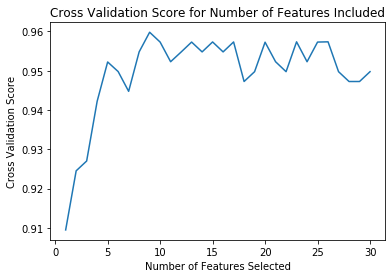

array([0.90949367, 0.92452532, 0.92702532, 0.94221519, 0.95221519,
       0.94977848, 0.94474684, 0.95477848, 0.95977848, 0.95727848,
       0.95227848, 0.95474684, 0.95727848, 0.95477848, 0.95731013,
       0.95477848, 0.95731013, 0.94724684, 0.94974684, 0.95724684,
       0.95227848, 0.94974684, 0.95734177, 0.95227848, 0.95727848,
       0.95734177, 0.94974684, 0.94724684, 0.94724684, 0.94974684])

In [13]:
plt.figure()
plt.title('Cross Validation Score for Number of Features Included')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
rfecv.grid_scores_

In [14]:
best_features = x_train.columns[rfecv.support_]
x_train = x_train[best_features]
x_test = x_test[best_features]

##### Summary of Feature Selection

We elected for a Recursive Feature Elimination with Cross Validation (RFECV) using a Random forest Classifier model to perform feature selection on the data set features. 

We plotted the cross validation score (cvs) vs the number of features and observed a maximized cvs when our model was trained on 9 features (0.959). The features are:

* 'perimeter_mean' 
* 'concavity_mean'
* 'concave points_mean'
* 'radius_worst' 
* 'texture_worst'
* 'perimeter_worst'
* 'area_worst',
* 'concavity_worst'
* 'concave points_worst'


#### Feature Visualization

Let's take a look at the features our RFECV process selected for our model

For the visualization of our features I will be using my favourite plot types I came across while completing this notebook.

* Density Plot
* Swarm Plot

***

Density Plots: A density plot is the graphical representation of a density estimation. A density estimation is the construction of an estimation of what an unobservable underlying probability density function would be based on our observed data set.

An advantage density plots have over histograms is that they're better at determining the distribution shape because they're not affected by the number of bins used (each bar used in a typical histogram).



In [15]:
malignant_data = data[data['diagnosis'] == 1]
benign_data = data[data['diagnosis'] == 0]

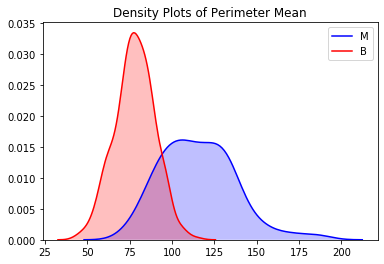

In [16]:
sns.kdeplot(malignant_data['perimeter_mean'], shade=True, color='b', label= 'M').set(title='Density Plots of Perimeter Mean')
sns.kdeplot(benign_data['perimeter_mean'], shade=True, color='r', label= 'B')
plt.legend()

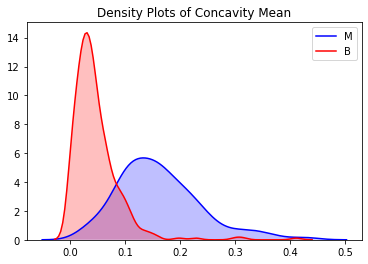

In [17]:
sns.kdeplot(malignant_data['concavity_mean'], shade=True, color='b', label= 'M').set(title='Density Plots of Concavity Mean')
sns.kdeplot(benign_data['concavity_mean'], shade=True, color='r', label= 'B')
plt.legend()

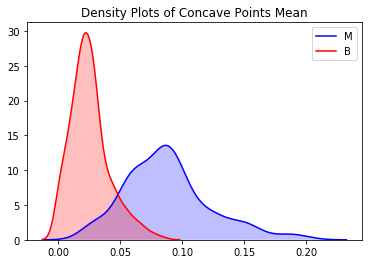

In [18]:
sns.kdeplot(malignant_data['concave points_mean'], shade=True, color='b', label= 'M').set(title='Density Plots of Concave Points Mean')
sns.kdeplot(benign_data['concave points_mean'], shade=True, color='r', label= 'B')
plt.legend()

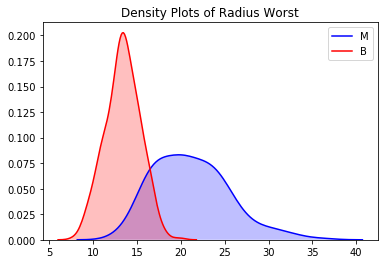

In [19]:
sns.kdeplot(malignant_data['radius_worst'], shade=True, color='b', label= 'M').set(title='Density Plots of Radius Worst')
sns.kdeplot(benign_data['radius_worst'], shade=True, color='r', label= 'B')
plt.legend()

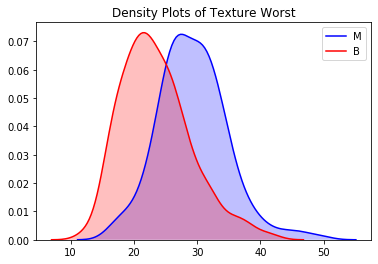

In [20]:
sns.kdeplot(malignant_data['texture_worst'], shade=True, color='b', label= 'M').set(title='Density Plots of Texture Worst')
sns.kdeplot(benign_data['texture_worst'], shade=True, color='r', label= 'B')
plt.legend()

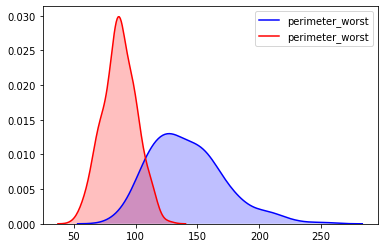

In [21]:
sns.kdeplot(malignant_data['perimeter_worst'], shade=True, color='b')
sns.kdeplot(benign_data['perimeter_worst'], shade=True, color='r')

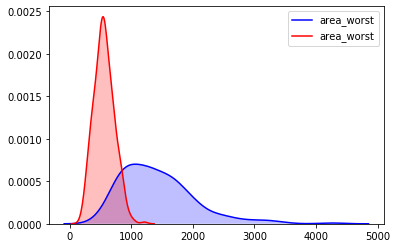

In [22]:
sns.kdeplot(malignant_data['area_worst'], shade=True, color='b')
sns.kdeplot(benign_data['area_worst'], shade=True, color='r')

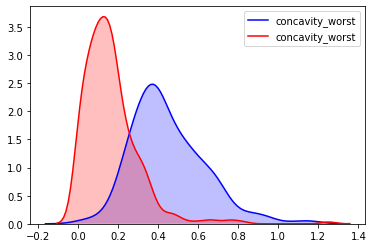

In [23]:
sns.kdeplot(malignant_data['concavity_worst'], shade=True, color='b')
sns.kdeplot(benign_data['concavity_worst'], shade=True, color='r')

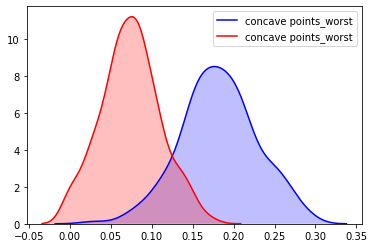

In [24]:
sns.kdeplot(malignant_data['concave points_worst'], shade=True, color='b')
sns.kdeplot(benign_data['concave points_worst'], shade=True, color='r')

***


Swarm Plots: A swarm plot plots the distribution of an attribute or the joint distribution of multiple attributes. 

I have elected to plot the joint distribution across the 9 best features we where given from our feature selection. Since the features are on different scales we must first normalize these features before plotting their joint distributions.

In [25]:
best_feat_list = best_features.to_list()
x = x[best_feat_list]
x_normalized = (x - x.mean())/x.std()
x_normalized['diagnosis'] = y
x_normalized

,perimeter_mean,concavity_mean,concave points_mean,radius_worst,texture_worst,perimeter_worst,area_worst,concavity_worst,concave points_worst,diagnosis
0,1.268817,2.650542,2.530249,1.885031,-1.358098,2.301575,1.999478,2.107672,2.294058,M
1,1.684473,-0.023825,0.547662,1.804340,-0.368879,1.533776,1.888827,-0.146620,1.086129,M
2,1.565126,1.362280,2.035440,1.510541,-0.023953,1.346291,1.455004,0.854222,1.953282,M
3,-0.592166,1.914213,1.450431,-0.281217,0.133866,-0.249720,-0.549538,1.987839,2.173873,M
4,1.775011,1.369806,1.427237,1.297434,-1.465481,1.337363,1.219651,0.612640,0.728618,M
...,...,...,...,...,...,...,...,...,...,...
564,2.058974,1.945573,2.318924,1.899514,0.117596,1.751022,2.013529,0.663928,1.627719,M
565,1.614511,0.692434,1.262558,1.535369,2.045599,1.420690,1.493644,0.236365,0.733182,M
566,0.672084,0.046547,0.105684,0.560868,1.373645,0.578492,0.427529,0.326479,0.413705,M
567,1.980781,3.294046,2.656528,1.959515,2.235958,2.301575,1.651717,3.194794,2.287972,M


Text(0.5, 1.0, 'Swarm Plot Selected Modeling Features')

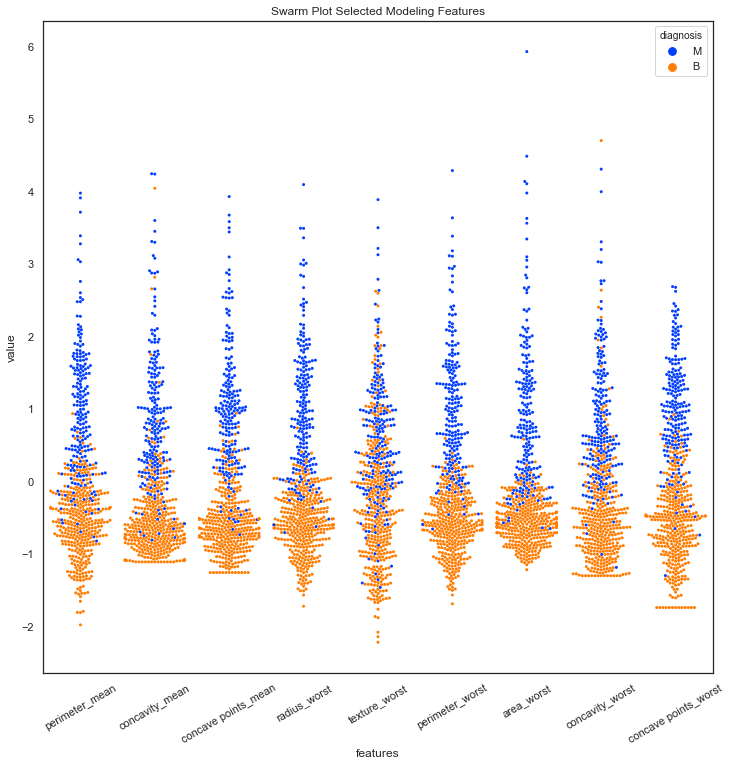

In [26]:
sns.set(style="white", palette="bright")
data = pd.melt(x_normalized, id_vars='diagnosis', var_name='features', value_name='value')
plt.figure(figsize=(12,12))
sns.swarmplot(data=data, x='features', y='value', hue='diagnosis', size = 3)
plt.xticks(rotation=30)
plt.title('Swarm Plot Selected Modeling Features')

From viewing the above distributions, we can see that most of the features our feature selection process selected for us (RFECV using a random forest classifier) have a distinct separation of the two classes.

#### Model Evaluation

***

The predictive accuracy or performance of a classification model can be broken down to the counts of correctly and incorrectly predicted test records. 

A confusion matrix is used to display the models counts of correctly and incorrectly predictions of a model. Am image of a confusion matrix can be viewed immediately after this cell and a description of each 

* True Positives (TP): The number of positive examples that the model correctly classified as positive. The number of malignant tumors our model classified as malignant

* True Negatives (TN): The number of negative examples that the model correctly classified as negative. The number of benign tumors our model classified as benign

* False Positives (FP): The number of negative examples that the model incorrectly classified as positive. The number of begign tumors our model classified as malignant

* False Negatives (FN): The number of positive examples that the model incorrectly classified as negative. The number of malignant tumors that our model classified as benign.

Accuracy: $Accuracy = TP + TN / TP + TN + FP + FN$

The accuracy metric is useful for model performance when the target class is well balanced with other classes in the input space. If the input space is skewed to one class or another the accuracy metric can become misleading about a models performance and other model performance metrics might be preferred.

Our data set consists of 357 malignant and 212 benign observations (1.68:1) is not so disproportional that the accuracy metric will still be a good indicator of model performance. 

Other performance metrics can still be of use to us for this classification. I would argue that minimizing the number of false negatives is of highest importance for any model we select. Below are two other very common classification metrics.  


True Positive Rate | Recall | Sensitivity:  $TPR = TP / TP + FN$ <br>

Precision: The ratio of correct positive classifications over the total number of predicted positive classifications. 
The closer this ratio is to 1 indicates a higher precision, meaning the model has a better ability to correctly classify positive observations

Positive Predictive Value | Precision: $PPV = TP / TP + FP$ <br>


Another way of saying this if we look above at the equation for recall, is that we want to maximize recall


In [27]:
Image(url='Confusion Matrix.PNG', width=400, height=300)

In [28]:
def calculate_sensitivity (con_matrix):
    return con_matrix[0,0] / (con_matrix[0,0] + con_matrix[1,0])

def calculate_precision (con_matrix):
    return con_matrix[0,0] / (con_matrix[0,0] + con_matrix[0,1])

#####  Logistic Regression
***

Score on train: 0.9597989949748744
Score on test: 0.9239766081871345
Sensitivity on test: 0.9203539823008849
Precision on test: 0.9629629629629629


Text(0.5, 1, 'Logistic Regression Confusion Matrix')

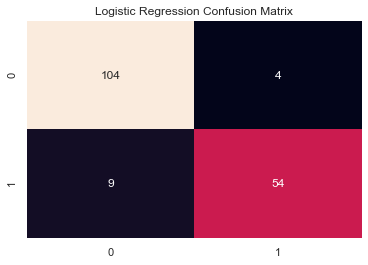

In [29]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=2000)
lr.fit(x_train, y_train)
cm = confusion_matrix(y_test, lr.predict(x_test))
print('Score on train: '+ str(lr.score(x_train, y_train)))
print('Score on test: ' + str(lr.score(x_test, y_test)))
print('Sensitivity on test: ' + str(calculate_sensitivity(cm)))
print('Precision on test: ' + str(calculate_precision(cm)))
sns.heatmap(cm,annot=True,fmt="d", cbar=False).set_title('Logistic Regression Confusion Matrix')

#####  K-Nearest Neighbours (KNN)
***

Score on train: 0.9296482412060302
Score on test: 0.9064327485380117
Sensitivity on test: 0.9181818181818182
Precision on test: 0.9351851851851852


Text(0.5, 1, 'KNN Confusion Matrix')

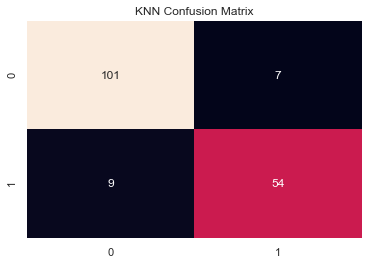

In [30]:
from matplotlib.pyplot import legend
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(x_train, y_train)
cm = confusion_matrix(y_test, knn.predict(x_test))
print("Score on train: "+ str(knn.score(x_train, y_train)))
print("Score on test: " + str(knn.score(x_test, y_test)))
print('Sensitivity on test: ' + str(calculate_sensitivity(cm)))
print('Precision on test: ' + str(calculate_precision(cm)))
sns.heatmap(cm,annot=True,fmt="d", cbar=False).set_title('KNN Confusion Matrix')

##### Decision Tree
***

score on train: 1.0
score on test: 0.9532163742690059
Sensitivity on test: 0.9385964912280702
Precision on test: 0.9907407407407407


Text(0.5, 1, 'Decision Tree Confusion Matrix')

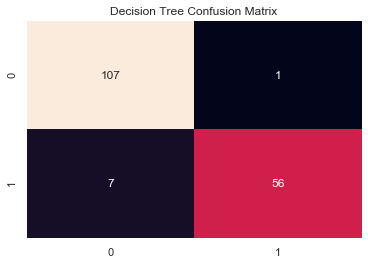

In [31]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
cm = confusion_matrix(y_test, dt_clf.predict(x_test))
print("score on train: " + str(dt_clf.score(x_train, y_train)))
print("score on test: "  + str(dt_clf.score(x_test, y_test)))
print('Sensitivity on test: ' + str(calculate_sensitivity(cm)))
print('Precision on test: ' + str(calculate_precision(cm)))
sns.heatmap(cm,annot=True,fmt="d", cbar=False).set_title('Decision Tree Confusion Matrix')

##### Random Forest
***

score on train: 1.0
score on test: 0.9473684210526315
Sensitivity on test: 0.9380530973451328
Precision on test: 0.9814814814814815


Text(0.5, 1, 'Random Forest Confusion Matrix')

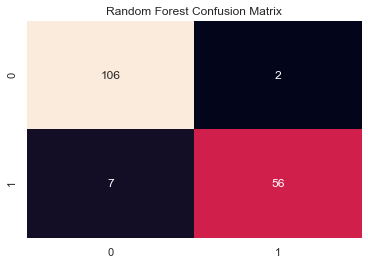

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)
cm = confusion_matrix(y_test, rf_clf.predict(x_test))
print("score on train: " + str(rf_clf.score(x_train, y_train)))
print("score on test: "  + str(rf_clf.score(x_test, y_test)))
print('Sensitivity on test: ' + str(calculate_sensitivity(cm)))
print('Precision on test: ' + str(calculate_precision(cm)))
sns.heatmap(cm,annot=True,fmt="d", cbar=False).set_title('Random Forest Confusion Matrix')

#### Conclusion

***

The takeaway from the above models is that this data is not particularly hard to classify as we see all models perform exceptionally well with all performance metrics > 0.9.

The perfect training score (1.0) for the decision tree and random forest classifiers on the training data I believe can be attributed to a highly separable input space simply meaning the data is not difficult to classify. The high score/accuracy on the testing data (0.95), out of sample data, also supports that the model is highly accurate and not overfit to our training data. Either decision tree model would be a fine model and preferred over the regression or KNN model as the accuracy and precision/recall value was greater for the tree classifiers.

***


<font color = 'grey'>
To Do:<br>

Include more models, some more with the selected features and some with built in feature selection.

Place model metrics into a dataframe for conclusion section

Title all images in notebook

Add more details to each section

